In [1]:
%load_ext autoreload
%autoreload 2
import os
print(os.getcwd())

os.environ['PM4PY_SHOW_EVENT_LOG_DEPRECATION'] = 'false'

/workspaces/codespaces-jupyter


In [2]:
import pandas as pd
import pm4py
import matplotlib.pyplot as plt

from pm4py.algo.discovery.dcr_discover import algorithm as discover_alg

from pm4py.objects.dcr.importer import importer as dcr_importer
from pm4py.objects.dcr.exporter import exporter as dcr_exporter

from pm4py.algo.conformance.dcr import algorithm as conformance_dcr
from pm4py.algo.conformance.alignments.dcr import algorithm as alignments_dcr
from pm4py.objects.dcr.obj import DcrGraph
from pm4py.objects.dcr.semantics import DcrSemantics

from pm4py.vis import view_events_distribution_graph,view_case_duration_graph

Note: The pm4py library we use in the notebook is an extension with DCR from the original pm4py library. You will find more information on using pm4py here

https://pm4py.fit.fraunhofer.de/documentation.

# Event log data analysis
Note: sepsis_df is a pandas dataframe. Feel free to use your knowledge of data frames and data analysis as you see fit. Exploratory Data Analysis (EDA) as you know it from Data Science should work as expected.

In [3]:
event_log_file = 'data/Sepsis Cases - Event Log.xes'
sepsis_df = pm4py.read_xes(event_log_file, infer_datetime_format=True) #loading the log
sepsis_df # note there are many NaN values, this is expected. When you have a not NaN value look at the concept:name to understand the link between the data attribute and the event.


/workspaces/codespaces-jupyter/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

,InfectionSuspected,org:group,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,concept:name,...,DiagnosticLacticAcid,lifecycle:transition,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,case:concept:name,Leucocytes,CRP,LacticAcid
0,True,A,True,True,True,True,True,True,True,ER Registration,...,True,complete,A,False,True,True,A,NaN,NaN,NaN
1,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leucocytes,...,NaN,complete,NaN,NaN,NaN,NaN,A,9.6,NaN,NaN
2,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,21.0,NaN
3,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LacticAcid,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,2.2
4,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER Triage,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15209,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,complete,NaN,NaN,NaN,NaN,KNA,NaN,66.0,NaN
15210,NaN,E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Release A,...,NaN,complete,NaN,NaN,NaN,NaN,KNA,NaN,NaN,NaN
15211,False,L,False,False,False,False,False,False,False,ER Registration,...,False,complete,NaN,False,False,False,LNA,NaN,NaN,NaN
15212,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER Triage,...,NaN,complete,NaN,NaN,NaN,NaN,LNA,NaN,NaN,NaN


In [4]:
returning = sepsis_df[sepsis_df['concept:name']=='Return ER']['case:concept:name'].unique().tolist()

In [5]:
sepsis_df.describe() # this will only describe numerical columns

,Age,Leucocytes,CRP,LacticAcid
count,1050.000000,3361.00000,3123.000000,1454.000000
mean,70.080952,12.94936,113.745757,1.949106
std,17.356744,14.99533,86.775355,1.478633
min,20.000000,0.20000,5.000000,0.200000
25%,60.000000,7.70000,43.000000,1.100000
50%,75.000000,11.00000,95.000000,1.600000
75%,85.000000,15.00000,162.000000,2.300000
max,90.000000,381.30000,573.000000,14.900000


In [6]:
sepsis_df.columns #list of all columns

Index(['InfectionSuspected', 'org:group', 'DiagnosticBlood', 'DisfuncOrg',
       'SIRSCritTachypnea', 'Hypotensie', 'SIRSCritHeartRate', 'Infusion',
       'DiagnosticArtAstrup', 'concept:name', 'Age', 'DiagnosticIC',
       'DiagnosticSputum', 'DiagnosticLiquor', 'DiagnosticOther',
       'SIRSCriteria2OrMore', 'DiagnosticXthorax', 'SIRSCritTemperature',
       'time:timestamp', 'DiagnosticUrinaryCulture', 'SIRSCritLeucos',
       'Oligurie', 'DiagnosticLacticAcid', 'lifecycle:transition', 'Diagnose',
       'Hypoxie', 'DiagnosticUrinarySediment', 'DiagnosticECG',
       'case:concept:name', 'Leucocytes', 'CRP', 'LacticAcid'],
      dtype='object')

In [7]:
#TODO add your code for question 1.1 

#How many cases are in total? 
total_cases_count = sepsis_df['case:concept:name'].nunique()
print(total_cases_count)

#And how many return to the ER? 
returning_to_er_count = len(returning)
print(returning_to_er_count)

1050
294


Example: number of cases with hypotension.

In [8]:
sepsis_df[sepsis_df['Hypotensie']==True]['case:concept:name'].nunique()

54

In [9]:
#TODO add your code for 1.2

#How many cases have infection suspected?
infection_suspected = sepsis_df[sepsis_df['InfectionSuspected']==True]['case:concept:name'].nunique()
print(infection_suspected)


848


Example: Mean (average) patient age. Note that age is related to "ER Registration" and patients with a higher than average age.

In [10]:
sepsis_df[sepsis_df['concept:name']=='ER Registration']['Age'].describe()

count    995.000000
mean      70.190955
std       17.384679
min       20.000000
25%       60.000000
50%       75.000000
75%       85.000000
max       90.000000
Name: Age, dtype: float64

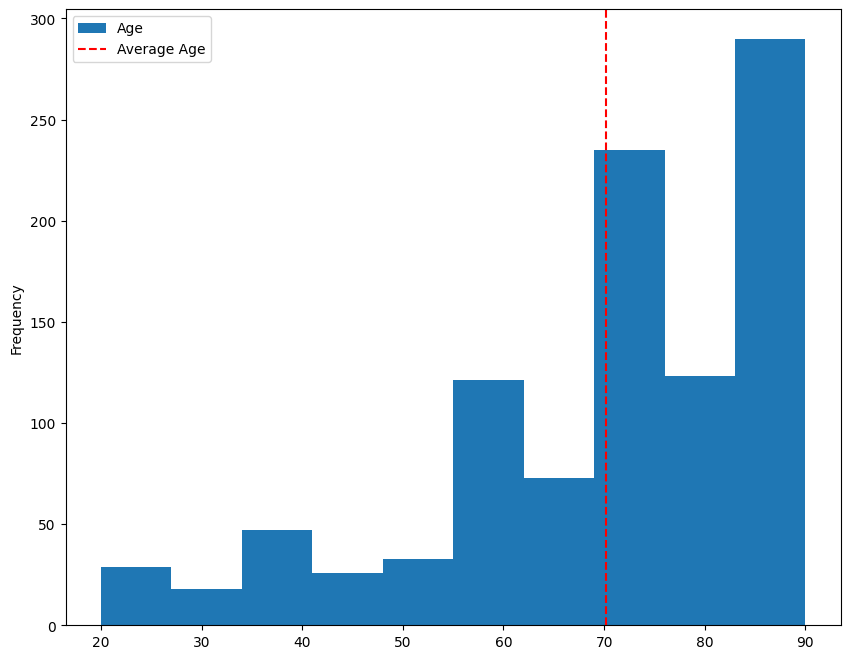

In [11]:
mean_age = sepsis_df[sepsis_df['concept:name']=='ER Registration']['Age'].mean()
ax = sepsis_df[sepsis_df['concept:name']=='ER Registration'].plot.hist(column=['Age'],figsize=(10, 8))
ax.axvline(x=mean_age,color='r',linestyle='--',label='Average Age')
ax.legend()

In [12]:
# Number of cases with a higher than average age according to the log
sepsis_df[(sepsis_df['Age']>mean_age) & (sepsis_df['concept:name']=='ER Registration')]['case:concept:name'].nunique()


543

In [13]:
#TODO add your code for 1.3. 

#Look at the measurement events only. What is the average (mean) measurement values for 

#Leucocytes
leucocytes_mean = sepsis_df[sepsis_df['concept:name']=='Leucocytes']['Leucocytes'].mean()
print(leucocytes_mean)

#CRP 
crp_mean = sepsis_df[sepsis_df['concept:name']=='CRP']['CRP'].mean()
print(crp_mean)

#LacticAcid
lacticacid_mean = sepsis_df[sepsis_df['concept:name']=='LacticAcid']['LacticAcid'].mean()
print(lacticacid_mean)



12.949360309431718
113.74575728466219
1.9491059147180192


In [14]:
#For each measurement type, find how many cases report at least one higher than average result?
leucocytes_high = sepsis_df[(sepsis_df['Leucocytes']>leucocytes_mean) & 
                            (sepsis_df['concept:name']=='Leucocytes')]['case:concept:name'].nunique()
print(leucocytes_high)

crp_high = sepsis_df[(sepsis_df['CRP']>crp_mean) & 
                     (sepsis_df['concept:name']=='CRP')]['case:concept:name'].nunique()
print(crp_high)

lacticacid_high = sepsis_df[(sepsis_df['LacticAcid']>lacticacid_mean) & 
                            (sepsis_df['concept:name']=='LacticAcid')]['case:concept:name'].nunique()
print(lacticacid_high)

533
544
345


# More descriptive statistics

## Activity Ocurrences

In [15]:
sepsis_df["concept:name"].value_counts()

concept:name
Leucocytes          3383
CRP                 3262
LacticAcid          1466
Admission NC        1182
ER Triage           1053
ER Registration     1050
ER Sepsis Triage    1049
IV Antibiotics       823
IV Liquid            753
Release A            671
Return ER            294
Admission IC         117
Release B             56
Release C             25
Release D             24
Release E              6
Name: count, dtype: int64

# Activities in Cases

In [16]:
sepsis_df.groupby(["case:concept:name", "concept:name"]).first().reset_index()["concept:name"].value_counts()

concept:name
ER Registration     1050
ER Triage           1050
ER Sepsis Triage    1049
Leucocytes          1012
CRP                 1007
LacticAcid           860
IV Antibiotics       823
Admission NC         800
IV Liquid            753
Release A            671
Return ER            294
Admission IC         110
Release B             56
Release C             25
Release D             24
Release E              6
Name: count, dtype: int64

# Start Activities

In [17]:
sepsis_df.groupby("case:concept:name").first()["concept:name"].value_counts()

concept:name
ER Registration     995
Leucocytes           18
IV Liquid            14
CRP                  10
ER Sepsis Triage      7
ER Triage             6
Name: count, dtype: int64

# End Activites

In [18]:
sepsis_df.groupby("case:concept:name").last()["concept:name"].value_counts()

concept:name
Release A           393
Return ER           291
IV Antibiotics       87
Release B            55
ER Sepsis Triage     49
Leucocytes           44
CRP                  41
LacticAcid           24
Release C            19
Admission NC         14
Release D            14
IV Liquid            12
Release E             5
ER Triage             2
Name: count, dtype: int64

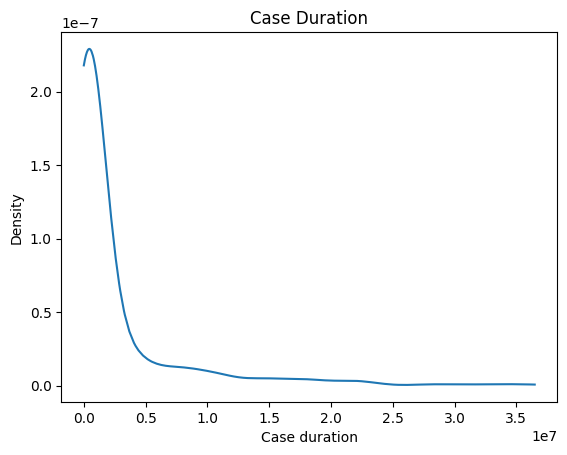

In [19]:
view_case_duration_graph(sepsis_df,kwargs={'pylot_plot_kwargs':{'linestyle':'-'}})

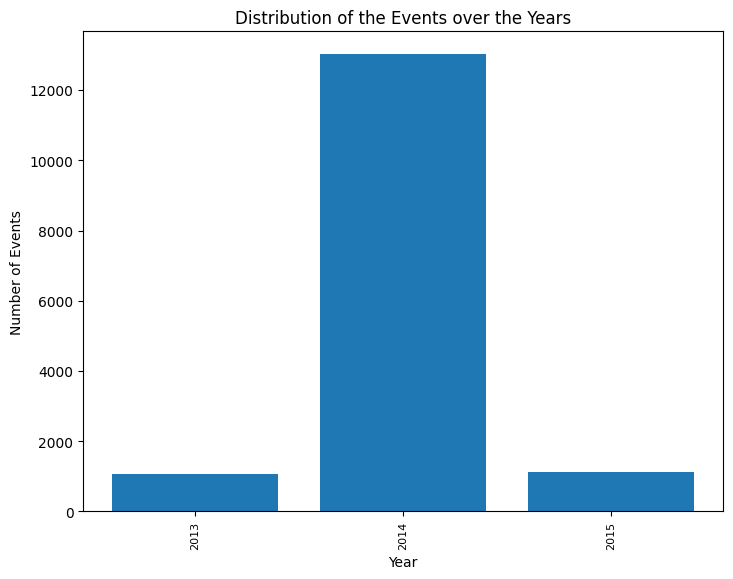

In [20]:
view_events_distribution_graph(sepsis_df,distr_type='years')

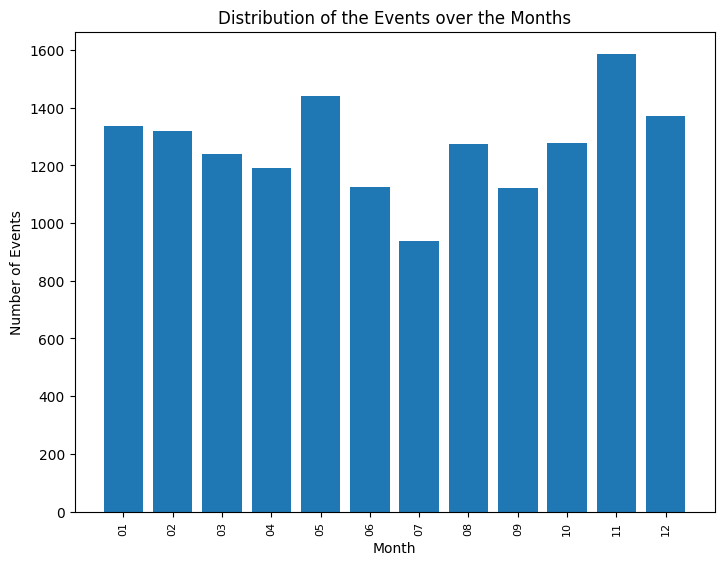

In [21]:
view_events_distribution_graph(sepsis_df,distr_type='months')

# Part 2.1 Process discovery
Note: The model mined with this version of DisCoveR is more complex than the one from the dcrgraphs.net portal. It finds more relations.

Note 2: 'conditionsFor' represents the inverse reading of a condition arrow (this was done for efficient checking of the enabledness definition). 
    For example, you should read that 'Release D' is a conditionFor 'Return ER' ('Release D'-->*'Return ER'), but in the python object you will see it as 'conditionsFor': 'Return ER' {'Release D',...

Note 3: The other relations 'includesTo' (-->+), 'excludesTo' (-->%), 'responseTo' (*-->) are represented in the python object in the same direction as the arrows indicate. 
    For example, 'excludesTo': { ... 'Return ER': {'Return ER', 'Release B' ... encodes the visual self exclusion on 'Return ER' and that 'Return ER' excludes 'Release B' ('Return ER' -->% 'Release B') 

In [22]:
dcr_sepsis_from_portal = dcr_importer.apply('models/sepsis_dcr_portal.xml')
print('Inspect the mined DCR Graph from the portal')
print(f'[Found relations] {dcr_sepsis_from_portal.get_constraints()}')
print(f'[conditionsFor] {dcr_sepsis_from_portal.conditions}')
print(f'[excludesTo] {dcr_sepsis_from_portal.excludes}')
# when you discover (mine) a DCR Graph the marking you get will have all events included, none executed and none pending
print(f'[marking executed] {dcr_sepsis_from_portal.marking.executed}')
print(f'[marking included] {dcr_sepsis_from_portal.marking.included}')
print(f'[marking pending] {dcr_sepsis_from_portal.marking.pending}')

OSError: Error reading file 'models/sepsis_dcr_portal.xml': failed to load external entity "models/sepsis_dcr_portal.xml"

In [ ]:
dcr_sepsis, log_abstraction = discover_alg.apply(sepsis_df) # this discovers a model for the whole log
print('Inspect the mined DCR Graph from pm4py')
print(f'[Found relations] {dcr_sepsis.get_constraints()}')
print(f'[conditionsFor] {dcr_sepsis.conditions}')
print(f'[excludesTo] {dcr_sepsis.excludes}')
# when you discover (mine) a DCR Graph the marking you get will have all events included, none executed and none pending
print(f'[marking executed] {dcr_sepsis.marking.executed}')
print(f'[marking included] {dcr_sepsis.marking.included}')
print(f'[marking pending] {dcr_sepsis.marking.pending}')

Example: play with the execution semantics in the notebook

In [ ]:
def execute_and_check(event_to_execute,dcr_graph, dcr_semantics):
    enabled_events = dcr_semantics.enabled(dcr_graph)
    print(f'[Before executing {event_to_execute}] Enabled events: {enabled_events}') # check enabled events
    if event_to_execute in enabled_events: # check if I can execute the event_to_execute
        dcr_graph_new_marking = dcr_semantics.execute(event_to_execute,dcr_graph) # here you execute the event and change the state of the dcr graph
        print(f'[ After executing {event_to_execute}] Enabled events: {dcr_semantics.enabled(dcr_graph_new_marking)}') # now these are the newly enabled events
        print(f'[Is the graph accepting?] {dcr_semantics.is_accepting(dcr_graph_new_marking)}')
        return dcr_graph_new_marking
    else:
        print(f'[Error!] {event_to_execute} not in the set of enabled events')
        return dcr_graph

dcr_semantics = DcrSemantics()
event_to_execute1 = 'CRP' # update this event in order to simulate the execution of the event
dcr_sepsis = execute_and_check(event_to_execute1,dcr_sepsis,dcr_semantics)
event_to_execute2 = 'ER Sepsis Triage' # update this event in order to simulate the execution of the event
dcr_sepsis = execute_and_check(event_to_execute2,dcr_sepsis,dcr_semantics)

2.3 (in the notebook): Now I can make 'Release D' pending. This has an effect on my acceptance criteria. Also I cannot execute 'Release D' yet, because I have to satisfy the condition chain which will eventually enable 'Release D'.
What is the minimal sequence of events I need to execute before I am able to execute 'Release D' and return into an accepting state for my DCR Graph? 

In [ ]:
dcr_sepsis, _ = discover_alg.apply(sepsis_df)
dcr_semantics = DcrSemantics()
dcr_sepsis.marking.pending.add('Release D')
print(f'[marking pending] {dcr_sepsis.marking.pending}')
#TODO: execute the minimum number of events to enable 'Release D'
dcr_sepsis = execute_and_check('Release D', dcr_sepsis, dcr_semantics)

In [ ]:
dcr_sepsis, _ = discover_alg.apply(sepsis_df) # we mine a fresh model because we've changed the marking by executing events
dcr_exporter.apply(dcr_sepsis,'models/sepsis_from_notebook.xml') #this exports your model into a file which you can import in the dcrgraphs.net portal. You can find the model in the models folder

In [ ]:
event_log_file_non_returning = 'data/sepsis_non_returning.xes'
event_log_file_returning = 'data/sepsis_returning.xes'
non_returning_df = pm4py.read_xes('data/sepsis_non_returning.xes')
returning_df = pm4py.read_xes('data/sepsis_returning.xes')
#TODO: 1.5 run DisCoveR, export to the models folder, load them into the portal, run some descriptive statistics as seen above on the two subsets.
non_returning_dcr, _ = discover_alg.apply(non_returning_df)
returning_dcr, _ = discover_alg.apply(returning_df)

In [ ]:
non_returning_dcr

In [ ]:
returning_dcr

# Part 2.2 Conformance checking
### Rule based conformance checking
Note: Testing for conformance on the same data you used to discover your model will always be a perfect fit

In [ ]:
dcr_sepsis, _ = discover_alg.apply(sepsis_df)
conformance_sepsis_df = pd.DataFrame(conformance_dcr.apply(sepsis_df,dcr_sepsis))
print(f'[Deviation fitness] {conformance_sepsis_df["dev_fitness"].mean()}')
conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]

In [ ]:
#TODO 2.2 Load the two models for conformance you created in the portal here
conformance_choice_path = 'models/ add your file name here.xml'
conformance_sequence_path = 'models/ add your file name here.xml'

### Choice conformance

In [ ]:
conformance_choice = dcr_importer.apply(conformance_choice_path)
conformance_sepsis_df = pd.DataFrame(conformance_dcr.apply(sepsis_df,conformance_choice))
print(f'[Deviation fitness] {conformance_sepsis_df["dev_fitness"].mean()}')
print('Conforming traces:',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==True]))
print('Non-conforming traces',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]))
conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]['deviations'].value_counts()

In [ ]:
conformance_choice = dcr_importer.apply(conformance_choice_path)
conformance_sepsis_df = pd.DataFrame(conformance_dcr.apply(non_returning_df,conformance_choice))
print(f'[Deviation fitness] {conformance_sepsis_df["dev_fitness"].mean()}')
print('Conforming traces:',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==True]))
print('Non-conforming traces',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]))
conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]['deviations'].value_counts()

In [ ]:
conformance_choice = dcr_importer.apply(conformance_choice_path)
conformance_sepsis_df = pd.DataFrame(conformance_dcr.apply(returning_df,conformance_choice))
print(f'[Deviation fitness] {conformance_sepsis_df["dev_fitness"].mean()}')
print('Conforming traces:',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==True]))
print('Non-conforming traces',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]))
conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]['deviations'].value_counts()

### Sequence conformance

In [ ]:
conformance_sequence = dcr_importer.apply(conformance_sequence_path)
conformance_sepsis_df = pd.DataFrame(conformance_dcr.apply(sepsis_df,conformance_sequence))
print(f'[Deviation fitness] {conformance_sepsis_df["dev_fitness"].mean()}')
print('Conforming traces:',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==True]))
print('Non-conforming traces',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]))
conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]['deviations'].value_counts()

In [ ]:
conformance_sequence = dcr_importer.apply(conformance_sequence_path)
conformance_sepsis_df = pd.DataFrame(conformance_dcr.apply(non_returning_df,conformance_sequence))
print(f'[Deviation fitness] {conformance_sepsis_df["dev_fitness"].mean()}')
print('Conforming traces:',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==True]))
print('Non-conforming traces',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]))
conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]['deviations'].value_counts()

In [ ]:
conformance_sequence = dcr_importer.apply(conformance_sequence_path)
conformance_sepsis_df = pd.DataFrame(conformance_dcr.apply(returning_df,conformance_sequence))
print(f'[Deviation fitness] {conformance_sepsis_df["dev_fitness"].mean()}')
print('Conforming traces:',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==True]))
print('Non-conforming traces',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]))
conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]['deviations'].value_counts()

# Other Discovery algorithms for imperative notations
### BPMN (observe the differences between the discovered model and the idealized one from the assignment 2.2 exercise)

In [ ]:
bpmn_sepsis = pm4py.discovery.discover_bpmn_inductive(sepsis_df)
pm4py.view_bpmn(bpmn_sepsis)

## BPMN filtering to discover only from 0.8 (80%) most common traces.

In [ ]:
bpmn_filtered = pm4py.discover_bpmn_inductive(sepsis_df, 0.8)
pm4py.view_bpmn(bpmn_filtered)

## Directly follows graph

In [ ]:
dfg, start_activities, end_activities = pm4py.discover_dfg(sepsis_df)
pm4py.view_dfg(dfg, start_activities, end_activities)

## A view of the Directly Follows Graph that shows only the top 20 most frequent edges

In [ ]:
pm4py.view_dfg(dfg, start_activities, end_activities, max_num_edges=20)

## Alignment based conformance
Note: Testing for conformance on the same data you used to discover your model will always be a perfect fit

In [ ]:
dcr_sepsis, _ = discover_alg.apply(sepsis_df)
alignment_sepsis_df = pd.DataFrame(alignments_dcr.apply(sepsis_df,DcrGraph(template=dcr_sepsis.obj_to_template())))
print(f'[Alignment fitness] {alignment_sepsis_df["fitness"].mean()}')
alignment_sepsis_df[alignment_sepsis_df['fitness']<1]

In [ ]:
conformance_choice = dcr_importer.apply('models/sepsis_conformance_admission_mutual_exclusion.xml')
alignment_sepsis_df = pd.DataFrame(alignments_dcr.apply(sepsis_df,DcrGraph(template=conformance_choice.obj_to_template())))
print(f'[Deviation fitness] {alignment_sepsis_df["fitness"].mean()}')
print(len(alignment_sepsis_df[alignment_sepsis_df['fitness']==1]))
print(len(alignment_sepsis_df[alignment_sepsis_df['fitness']!=1]))
alignment_sepsis_df[alignment_sepsis_df['fitness']!=1]['alignment'].value_counts()

In [ ]:
conformance_sequence = dcr_importer.apply('models/sepsis_conformance_registration_triage_chain.xml')
alignment_sepsis_df = pd.DataFrame(alignments_dcr.apply(sepsis_df,DcrGraph(template=conformance_sequence.obj_to_template())))
print(f'[Deviation fitness] {alignment_sepsis_df["fitness"].mean()}')
print(len(alignment_sepsis_df[alignment_sepsis_df['fitness']==1]))
print(len(alignment_sepsis_df[alignment_sepsis_df['fitness']!=1]))
alignment_sepsis_df[alignment_sepsis_df['fitness']!=1]['alignment'].value_counts()